## ECG Analysis


#### Possibly useful packages
- [ECG cleaning and more](https://neuropsychology.github.io/NeuroKit/functions/ecg.html)

### Sprint 1
- Data cleaning
- Exploratory Data Analysis (Patient Metadata and Medical)
- Fourier Analysis (ECGs themselves)
    - Noise removal 
    - Detecting arrhythmia
    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wfdb
%autosave 300

Autosaving every 300 seconds


We will use the `wfdb` package to read our files 

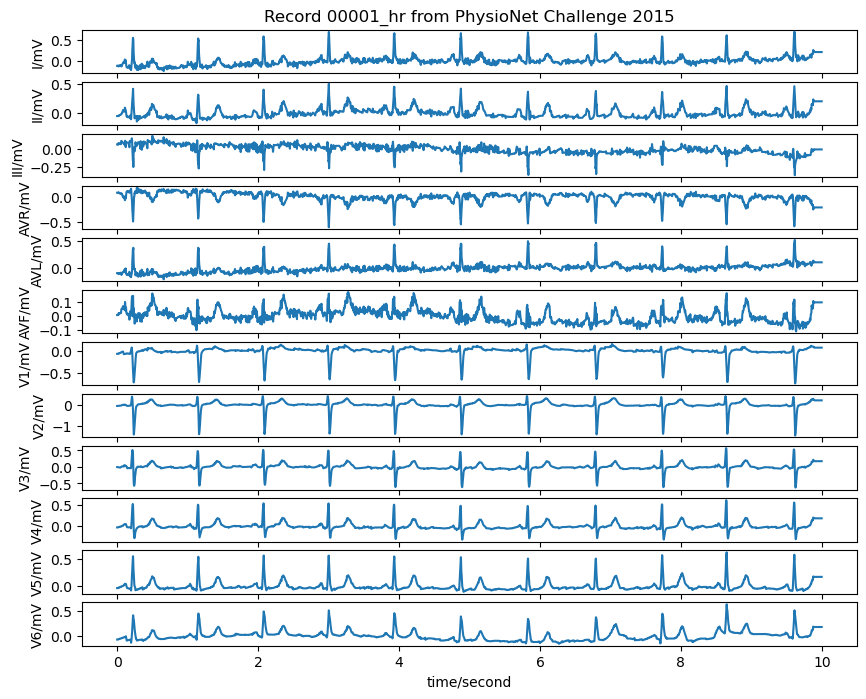

In [3]:
path = '../data/physionet.org/files/ptb-xl/1.0.3/records500/00000/'

record = wfdb.rdrecord(path+'00001_hr')
wfdb.plot_wfdb(record=record, title='Record 00001_hr from PhysioNet Challenge 2015', figsize=(10,8)) 
#display(record.__dict__)

Metadata: 
 {'fs': 500, 'sig_len': 5000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['I'], 'comments': []}


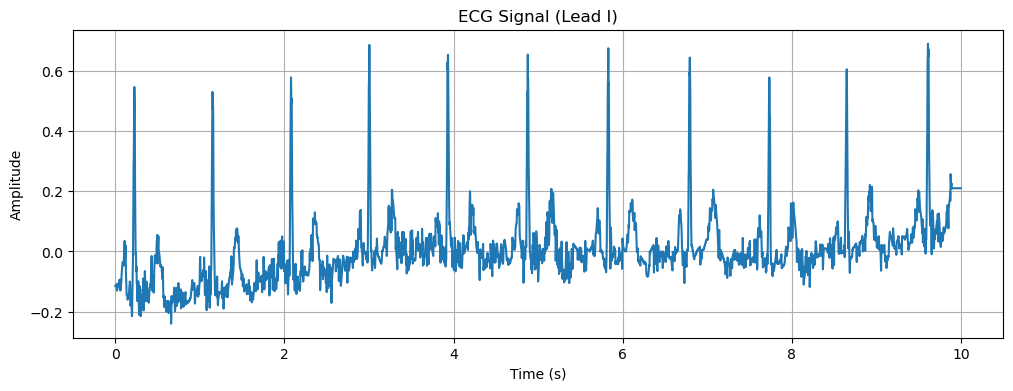

In [4]:
file = path+'00001_hr'


# Read signal and metadata
signals, fields = wfdb.rdsamp(file, channels=[0])  # Change channels=[0] based on your needs

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Print metadata
print("Metadata: \n", fields)

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency
#time = [i / sampling_frequency for i in range(sig_len)]

# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time, signals)
plt.title('ECG Signal (Lead {})'.format(sig_name[0]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### Fourier Analysis 

**Example 1**
- Testing out FFT on ECG above

First we get the sampling interval, $T$. We know that $T = \frac{1}{f_s}$ where $f_s$ is the sampling frequency. 

In [5]:
# First we get the sampling interval 
dt = 1/sampling_frequency

Note that the ECG signal is given in a 2D array. We need to convert it to 1D before applying FFT.
> The following method was taken from [here](https://dsp.stackexchange.com/questions/53272/fourier-transform-of-ecg-signal-in-python).

In [6]:
# Flatten the signal from 2D to 1D 
signals = signals.flatten()

Finally, we can calculate the FFT and plot it 

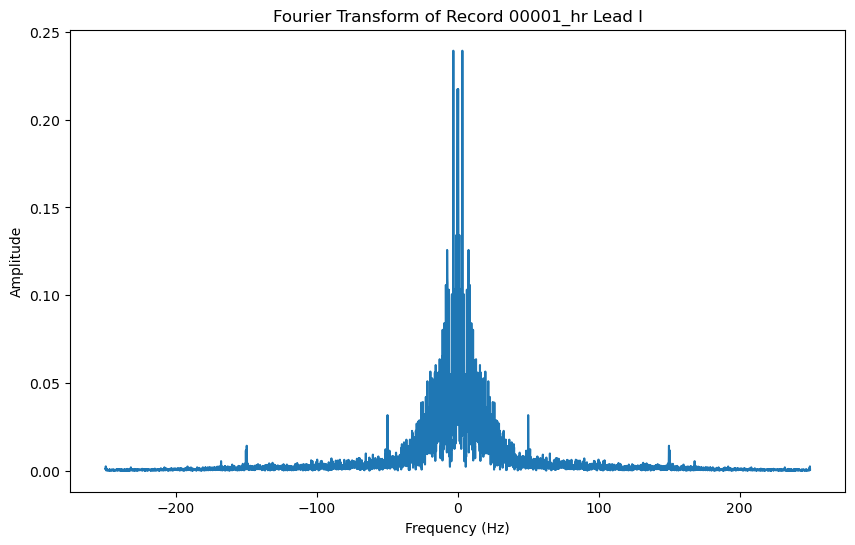

In [7]:
# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

plt.figure(figsize=(10,6))
plt.plot(freq, np.abs(signal_fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Record 00001_hr Lead %s' % (sig_name[0]))
# plt.xlim(-200, 200)
plt.show()

**Example 2**
- Let's try to do the same thing for lead V4 which has less artifact in it

Metadata: 
 {'fs': 500, 'sig_len': 5000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['V4'], 'comments': []}


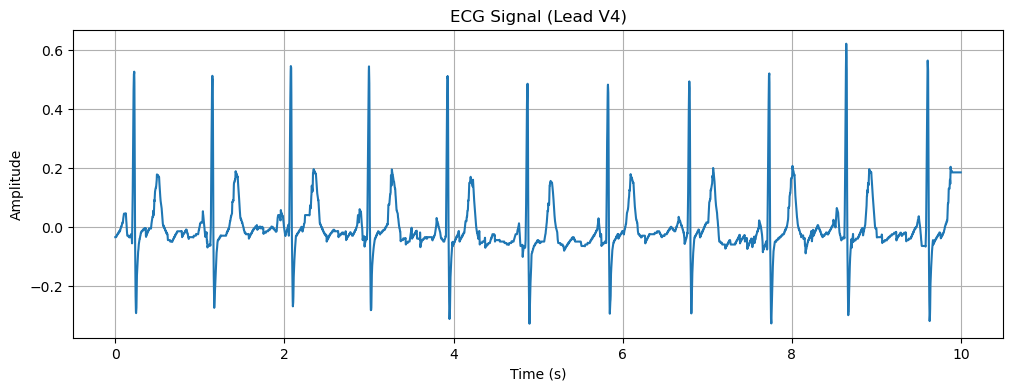

In [8]:
# Read signal and metadata
signals, fields = wfdb.rdsamp(file, channels=[9])  # Change channels=[0] based on your needs

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Print metadata
print("Metadata: \n", fields)

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency
#time = [i / sampling_frequency for i in range(sig_len)]

# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time, signals)
plt.title('ECG Signal (Lead {})'.format(sig_name[0]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

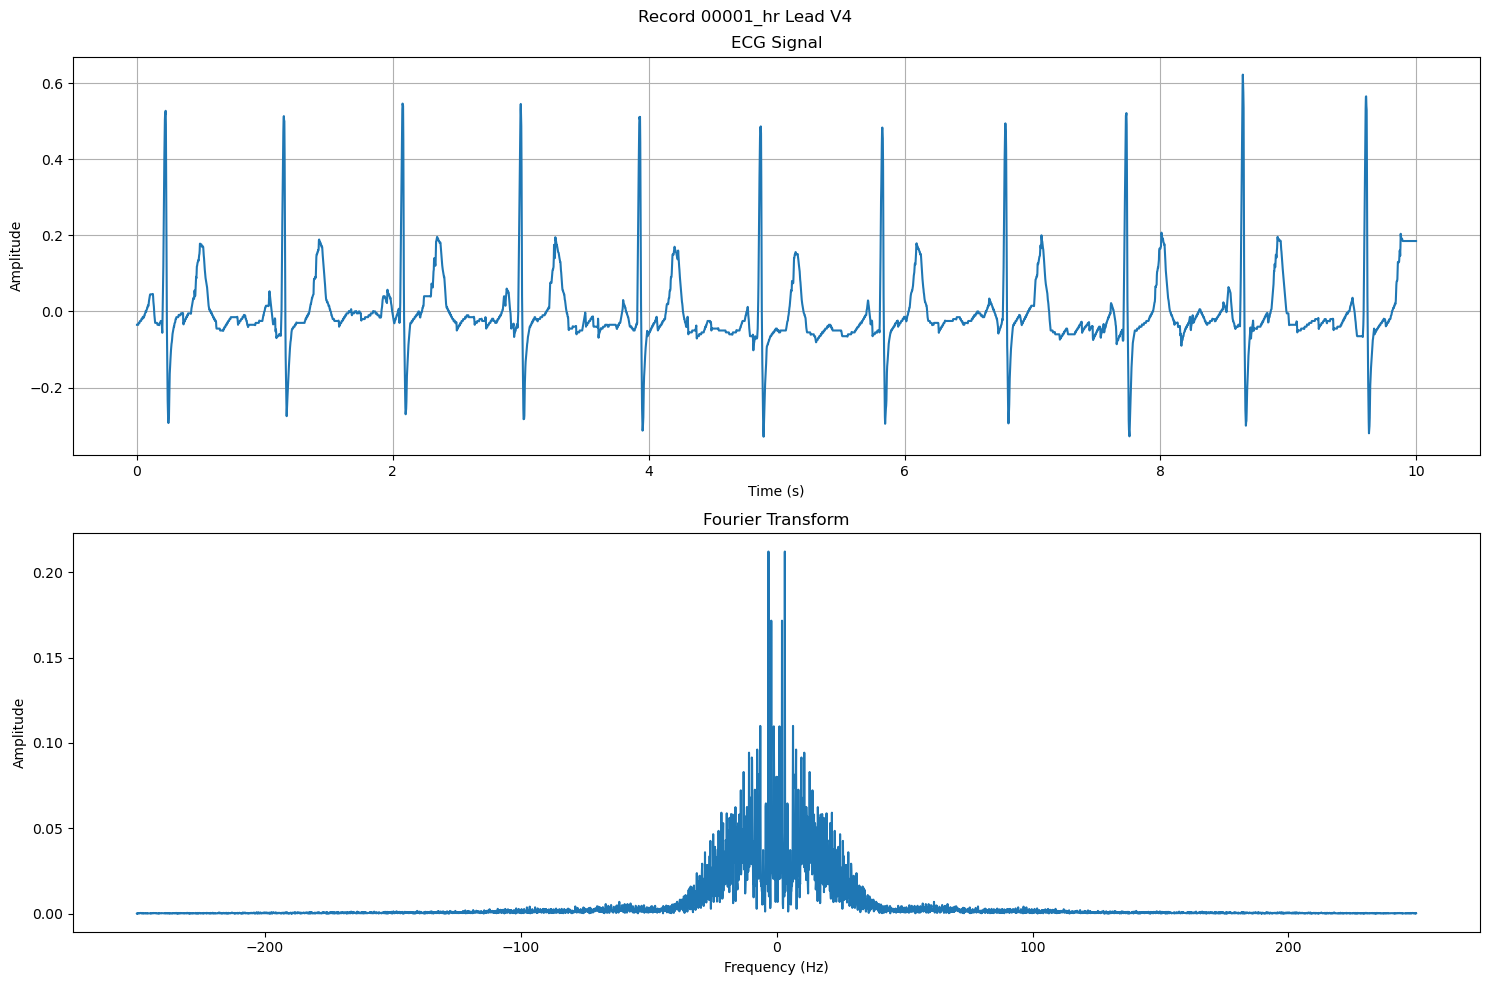

In [25]:
# First we get the sampling interval 
dt = 1/sampling_frequency

# Flatten the signal from 2D to 1D 
signals = signals.flatten()

# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

fig, ax = plt.subplots(2, 1, figsize=(15,10))

fig.suptitle("Record 00001_hr Lead %s" % (sig_name[0]))
ax[0].plot(time, signals)
ax[0].set_title('ECG Signal')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)
ax[1].plot(freq, np.abs(signal_fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Fourier Transform')
fig.tight_layout()
# plt.xlim(-100, 100)

### Annotations

**Data Dictionanry**

- diagnosis : 
- description : 
- diagnoastic
- form :
- rhythm :
- diagnostic class :
- dignostic subclass : 
- Statement Category : 
- SCP-ECG Statement Description : 
- AHA code :
- aECG REFID :
- CDISC Code : 
- DICOM Code :

**ECG Classes**

| # Records | Superclass | Description            | Common Name                      |
|-----------|------------|------------------------|--------------------------------- |
| 9514      | NORM       | Normal ECG             | Normal                           |
| 5469      | MI         | Myocardial Infarction  | Heart Attack                     |
| 5235      | STTC       | ST/T Change            | Changes in ST Segment and T Wave |
| 4898      | CD         | Conduction Disturbance | Heart Blocks                     |
| 2649      | HYP        | Hypertrophy            | Enlarged Cardiac Muscles         |

In [15]:
reports = pd.read_csv('../data/physionet.org/files/ptb-xl/1.0.3/scp_statements.csv')

In [16]:
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     71 non-null     object 
 1   description                    71 non-null     object 
 2   diagnostic                     44 non-null     float64
 3   form                           19 non-null     float64
 4   rhythm                         12 non-null     float64
 5   diagnostic_class               44 non-null     object 
 6   diagnostic_subclass            44 non-null     object 
 7   Statement Category             71 non-null     object 
 8   SCP-ECG Statement Description  71 non-null     object 
 9   AHA code                       37 non-null     float64
 10  aECG REFID                     23 non-null     object 
 11  CDISC Code                     13 non-null     object 
 12  DICOM Code                     13 non-null     objec

In [17]:
reports.head()

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [18]:
reports.rename(columns={'Unnamed: 0': 'diagnosis'}, inplace=True)

In [28]:
reports['diagnostic_class'].unique()

array(['STTC', 'NORM', 'MI', 'HYP', 'CD', nan], dtype=object)